# NYC MoMA Artworks - Collections Intake Forecasting


## Introduction


## Table of Contents
<ol>
  <li><a href="#load-libraries">Load libraries</a></li>
  <li><a href="#data-process">Data Preprocessing</a></li>
  <li><a href="#ts-decomp">Overall Time Series Decomposition</a></li>
  <li><a href="#spatial">Spatial Time Series Analysis</a></li>
  <ol>
    <li><a href="#spatial-ts">Analysis of Space-use over Time</a></li>
  </ol>
  <li><a href="#ts-model-declare">Time Series Model Initialization</a></li>
  <li><a href="#ts-model">Time Series Model Comparisons</a></li>
  <ol>
    <li><a href="#ts-model-tv">Time Series Model Training & Validation</a></li>
    <li><a href="#ts-model-forecast">Time Series Forecasting Estimates</a></li>
  </ol>
  <li><a href="#conclusions">Conclusions</a></li>
  <li><a href="#recommendations">Recommendations</a></li>
</ol>

<section id="load-libraries">
    <h2>Load Libraries</h2>
</section>

In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns
from darts import TimeSeries
from darts.models import (NaiveDrift, NaiveMovingAverage, ExponentialSmoothing, LinearRegressionModel,
                            RegressionModel, Croston, CatBoostModel, RandomForest, LightGBMModel,
                            NaiveEnsembleModel, RegressionEnsembleModel)
from sklearn.linear_model import LogisticRegression
from darts.explainability.shap_explainer import ShapExplainer
from darts.utils.statistics import (check_seasonality, stationarity_tests, plot_acf, plot_pacf, 
                                    plot_residuals_analysis, fill_missing_values)
import darts.metrics as metrics
import statsmodels.api as sm
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
from matplotlib import ticker
import warnings

sns.set_palette("colorblind")
pd.set_option("display.float_format", "{:0,.2f}".format)
warnings.filterwarnings("ignore")

C:\Users\lilyc\Desktop\human_docs\work\MMM\Museum Analytics Consulting\examples\NYC_MoMA_Example\nyc-moma-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define Necessary Functions
def remove_outliers(dataset, lower = 0.25, upper = 0.75):
    # Remove numerical outliers from the dataset
    dataset.astype(np.float64)
    Q1 = dataset.quantile(lower)
    Q3 = dataset.quantile(upper)
    IQR = Q3 - Q1
    lower_outliers = Q1 - (1.5 * IQR)
    upper_outliers = Q3 + (1.5 * IQR)

    return dataset[(dataset > lower_outliers) & (dataset < upper_outliers)]


def gen_ts_features(df, date_column, more_columns):
    # Generates Time Series Features based on date_column
    # Makes for easier analysis of operational (day-to-day) processes.
    out = df[[date_column] + more_columns].copy()
    out[date_column] = pd.to_datetime(out[date_column], format = "%m/%d/%Y", errors = "coerce")
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    out["weekday"] = pd.Categorical(out[date_column].dt.day_name(), categories = weekday_order, ordered = True)
    out["day_of_month"] = out[date_column].dt.day.astype(int)
    out["day_of_year"] = out[date_column].dt.dayofyear.astype(int)
    out["week_of_month"] = (out[date_column].dt.day / 7).apply(lambda x: np.ceil(x)).astype(int)
    out["week"] = out[date_column].dt.isocalendar().week.astype(int)
    out["month"] = out[date_column].dt.month.astype(int)
    out["year"] = out[date_column].dt.isocalendar().year.astype(int)
    return out


def is_stationary(series):
    # Hypothesis Testing for Time Series data
    # Perform two separate stationarity tests
    result = stationarity_tests(series, p_value_threshold_adfuller=0.05, p_value_threshold_kpss=0.05)

    if result:
        print("The time series is stationary.")
    else:
        print("The time series is non-stationary.")
    return result


def has_seasonality(series):
    result = check_seasonality(series)

    if result[0]:
        print(f"The time series has seaonality, with a period of {result[1]}")
    else:
        print("The time series does not have seasonality.")
    return result

In [3]:
# Data Preprocessing
dataset = (pd.read_csv("NYC-MoMA-Recent-Collections_TS.csv", index_col=0)
.sort_values("acquisition_date")
.drop(columns =["acq_gaps"])
)
dataset.loc[:, "acq_total"] = pd.to_numeric(dataset["acq_total"], errors="coerce")

# Importing external datasets to extend and enhance forecasts
# IMLS Grants Awarded (1998 -- 2024), National, Annual -> State, Daily
IMLS_grants_data = (pd.read_csv("./data/IMLS-awarded-grants-1998-2024.csv", 
                                usecols = ["Fiscal Year", "Federal Funds", "State"]))
IMLS_grants_data.loc[:, "Federal Funds"] = IMLS_grants_data["Federal Funds"].apply(lambda x: float(x.strip().replace("$", "").replace(",", "")))
NYC_IMLS_grants_subset = (IMLS_grants_data
                          [IMLS_grants_data["State"] == "NY"]
                          .groupby("Fiscal Year")
                          .sum()
                          .drop("State", axis = 1)
                          .reset_index())
NYC_IMLS_grants_subset["Date"] = pd.to_datetime(NYC_IMLS_grants_subset["Fiscal Year"].astype(str) + "-01-01")
NYC_IMLS_grants_subset = NYC_IMLS_grants_subset.set_index("Date").resample("D").ffill().drop("Fiscal Year", axis = 1)
NYC_IMLS_grants_subset["Federal Funds"] = NYC_IMLS_grants_subset["Federal Funds"].interpolate(method='linear')

# NEH Grants Awarded (1967 -- 2024), National, Annual -> State, Daily
NEH_grants_data = (pd.read_csv("./data/NEHGrantAwards1967_2024.csv", 
                               usecols = ["Organization State", "Year Awarded",
                                          "Awarded Outright Funds", "Awarded Matching Funds"])
                   .astype({"Year Awarded" : "int",
                            "Awarded Outright Funds": "float", 
                            "Awarded Matching Funds": "float"}))
NEH_grants_data["Total Awarded Funds"] = NEH_grants_data["Awarded Outright Funds"] + NEH_grants_data["Awarded Matching Funds"]
NYC_NEH_grants_subset = (NEH_grants_data
                         [NEH_grants_data["Organization State"] == "NY"]
                         .groupby("Year Awarded")
                         .sum()
                         .drop(["Awarded Outright Funds", "Awarded Matching Funds", "Organization State"], axis = 1)
                         .reset_index())
NYC_NEH_grants_subset["Date"] = pd.to_datetime(NYC_NEH_grants_subset["Year Awarded"].astype(str) + "-01-01")
NYC_NEH_grants_subset = NYC_NEH_grants_subset.set_index("Date").resample("D").ffill().drop("Year Awarded", axis = 1)
NYC_NEH_grants_subset["Total Awarded Funds"] = NYC_NEH_grants_subset["Total Awarded Funds"].interpolate(method='linear')

# US Consumer-Price Index data (1913 -- 2024), National, Monthly -> National, Daily
US_CPI_data = pd.read_csv("./data/US-CPI_1913-2024.csv")
US_CPI_data = (pd.melt(US_CPI_data, 
                       id_vars = "Year", 
                       var_name = "Month", 
                       value_name = "CPI"))
US_CPI_data["Date"] = pd.to_datetime(US_CPI_data["Year"].astype(str)
                                     +"-" + pd.to_datetime(US_CPI_data.Month, format='%b').dt.month.astype(str)
                                     + "-01")
US_CPI_data = US_CPI_data.set_index("Date").resample("D").ffill().drop(["Year", "Month"], axis = 1)
US_CPI_data["CPI"] = US_CPI_data["CPI"].interpolate(method='linear')

# NYC weather conditions (1869 -- 2022), City, Daily
NYC_weather_data = (pd.read_csv("./data/NYC_Central_Park_weather_1869-2022.csv"))
NYC_weather_data["Date"] = pd.to_datetime(NYC_weather_data["DATE"])
NYC_weather_data = NYC_weather_data.set_index("Date").drop("DATE", axis =1)

external_datasets = pd.merge(NYC_IMLS_grants_subset, NYC_NEH_grants_subset, on='Date', how='outer')
external_datasets = pd.merge(external_datasets, NYC_weather_data, on='Date', how='outer')
external_datasets = pd.merge(external_datasets, US_CPI_data, on='Date', how='outer')

clean_dataset = (dataset.astype({
    "acquisition_date": "datetime64[ns]",
    "department": "category",
    "credit_group": "category",
    "storage_group": "category",
    "weekday": "category",
    })
    .drop(columns = ["height_ft", "width_ft", "depth_ft", "cubic_ft", "spatial_running_total"]))

# Merge exogenous columns back onto groupby
daily_acq_groupby = (clean_dataset.set_index("acquisition_date").resample("D").agg({
    "acq_total": "sum",
    "day_of_month": "mean",
    "day_of_year": "mean",
    "week": "mean",
    "month": "mean",
    "year": "mean",
    "department": lambda x: x.mode()[0] if not x.mode().empty else None,
    "credit_group": lambda x: x.mode()[0] if not x.mode().empty else None,
    "storage_group": lambda x: x.mode()[0] if not x.mode().empty else None,
    "weekday": lambda x: x.mode()[0] if not x.mode().empty else None,
}).reset_index())

daily_acq_groupby = daily_acq_groupby.astype({
    "day_of_month": "float",
    "day_of_year": "float",
    "week": "float",
    "month": "float",
    "year": "float",
})

external_datasets = (external_datasets
                     [external_datasets.index > daily_acq_groupby["acquisition_date"].min()]
                     .reset_index())

In [4]:
daily_acq_groupby.dtypes

acquisition_date    datetime64[ns]
acq_total                  float64
day_of_month               float64
day_of_year                float64
week                       float64
month                      float64
year                       float64
department                category
credit_group              category
storage_group             category
weekday                   category
dtype: object

In [5]:
total_nulls = daily_acq_groupby.isna().sum()
total_nulls

acquisition_date       0
acq_total              0
day_of_month        9981
day_of_year         9981
week                9981
month               9981
year                9981
department          9981
credit_group        9981
storage_group       9981
weekday             9981
dtype: int64

In [6]:
print("Total number of null records:", max(total_nulls))
print("Null record density (%):  {:0.3f}%".format((max(total_nulls) / daily_acq_groupby.shape[0]) * 100))

Total number of null records: 9981
Null record density (%):  91.101%


In [7]:
# daily_acq_groupby["acquisition_date"] = pd.DatetimeIndex(daily_acq_groupby["acquisition_date"])

# Encode categorical columns as integers
label_encoders = defaultdict()
for column in ["department", "credit_group", "storage_group"]:
    le = LabelEncoder()
    daily_acq_groupby[column] = le.fit_transform(daily_acq_groupby[column])
    label_encoders[column] = le

oe = OrdinalEncoder()
daily_acq_groupby["weekday"] = oe.fit_transform(np.array(daily_acq_groupby["weekday"]).reshape(1, -1)).reshape(-1, 1)
label_encoders["weekday_ordinal"] = oe

# Replace missing values by referencing the values of (7) neighbors
for column in ["acq_total", "day_of_month", "day_of_year", "week", "weekday", "month", "year", "department", "credit_group", "storage_group"]:
    variable_imputer = KNNImputer(n_neighbors = 7)
    daily_acq_groupby.loc[:, column] = variable_imputer.fit_transform(np.array(daily_acq_groupby[column]).reshape(-1, 1))

for column in ["Total Awarded Funds", "PRCP", "SNOW", "SNWD", "TMIN", "TMAX"]:
    variable_imputer = KNNImputer(n_neighbors = 7)
    external_datasets.loc[:, column] = variable_imputer.fit_transform(np.array(external_datasets[column]).reshape(-1, 1))

# Adding lag features
# lags = [1, 2, 3, 4, 5]  # Number of lags to create
lags = [8, 14]
for lag in lags:
    daily_acq_groupby[f'acq_total_lag_{lag}'] = daily_acq_groupby['acq_total'].shift(lag)

In [8]:
daily_acq_groupby.isna().sum()

acquisition_date     0
acq_total            0
day_of_month         0
day_of_year          0
week                 0
month                0
year                 0
department           0
credit_group         0
storage_group        0
weekday              0
acq_total_lag_8      8
acq_total_lag_14    14
dtype: int64

In [9]:
# Dataset comparison - Record Loss
records = daily_acq_groupby.shape[0]
final_dataset = daily_acq_groupby.dropna().drop_duplicates("acquisition_date")
no_nulls = final_dataset.shape[0]

In [10]:
print("Number of Records before dropping nulls:", records)
print("Number of Records after dropping nulls:", no_nulls)
print("\n# of Records dropped: {:.2f}".format(np.abs(no_nulls - records)))
print("% of Records dropped: {:.2f}%".format(((records - no_nulls) / (records)) * 100))

Number of Records before dropping nulls: 10956
Number of Records after dropping nulls: 10942

# of Records dropped: 14.00
% of Records dropped: 0.13%


In [11]:
# Non-count variables
# final_dataset["acquisition_date"] = pd.to_datetime(final_dataset["acquisition_date"])
# exogenous_data["index"] = pd.to_datetime(exogenous_data["index"])

past_covariate_columns = [
    "day_of_month", "month", "weekday",
    "department", "credit_group", "storage_group", 
    "acq_total_lag_8", "acq_total_lag_14",
    # "acq_total_lag_1", "acq_total_lag_2", "acq_total_lag_3",
    # "acq_total_lag_4", "acq_total_lag_5"
]
final_dataset["acquisition_date"] = pd.to_datetime(final_dataset["acquisition_date"])

# past covariates
past_covariates = TimeSeries.from_dataframe(final_dataset, "acquisition_date", past_covariate_columns, fill_missing_dates=True, freq="D")

# future covariates
future_covariates = TimeSeries.from_dataframe(external_datasets, "Date", fill_missing_dates = True, freq = "D")

# time + variable for estimation
target_series = TimeSeries.from_dataframe(final_dataset, "acquisition_date",  "acq_total", fill_missing_dates=True, freq="D")

In [12]:
# Check for seasonality and stationarity
check_seasonality(target_series)

(True, 2)

In [13]:
stationarity_tests(target_series)

False

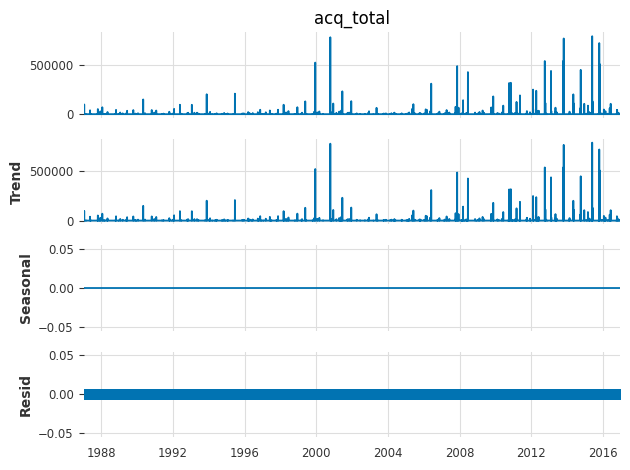

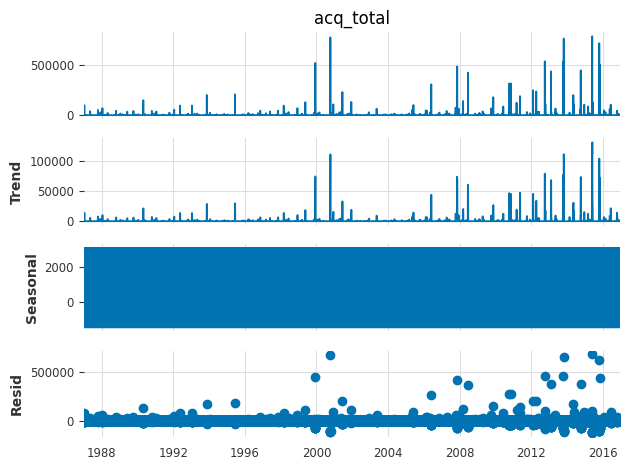

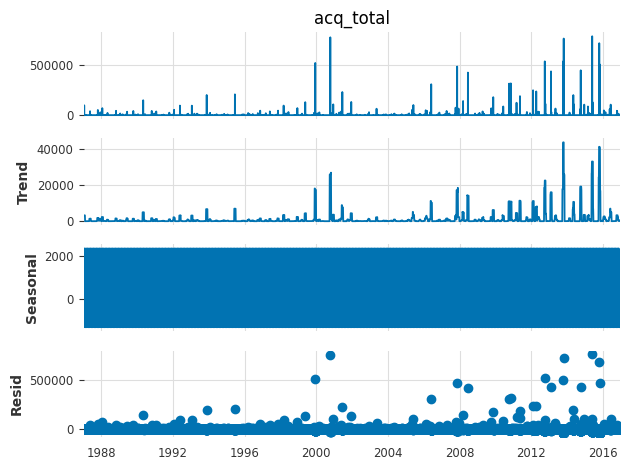

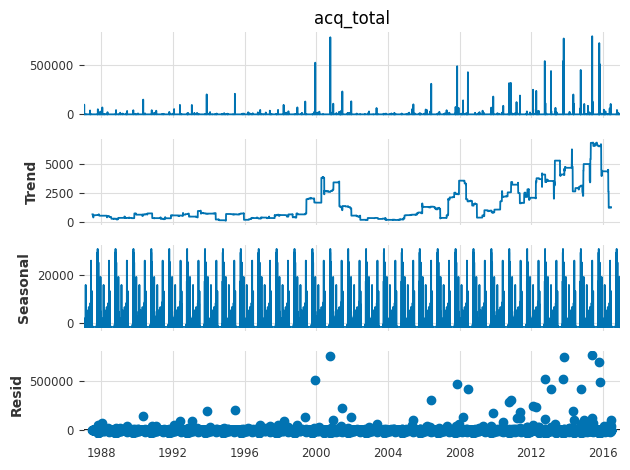

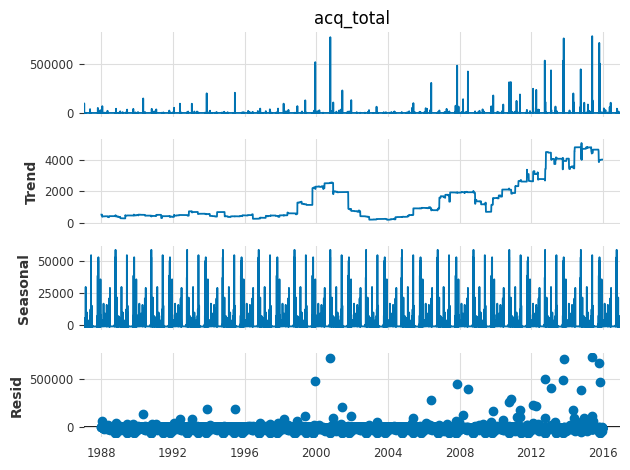

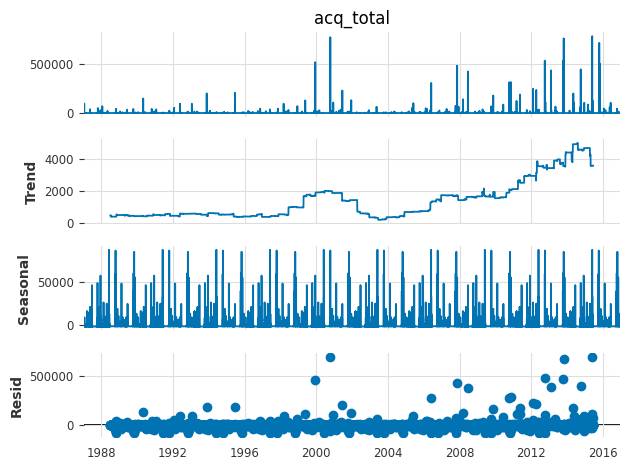

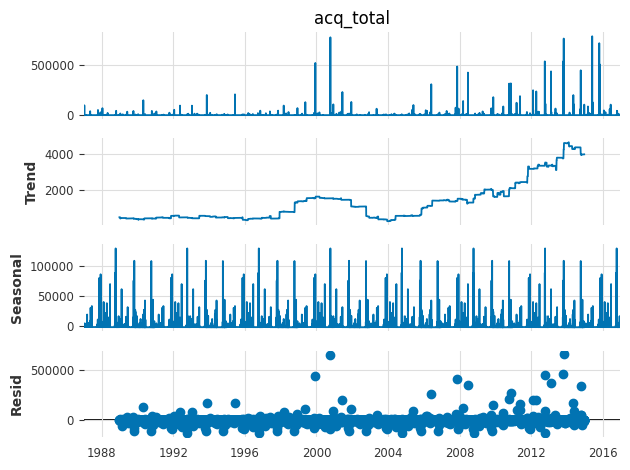

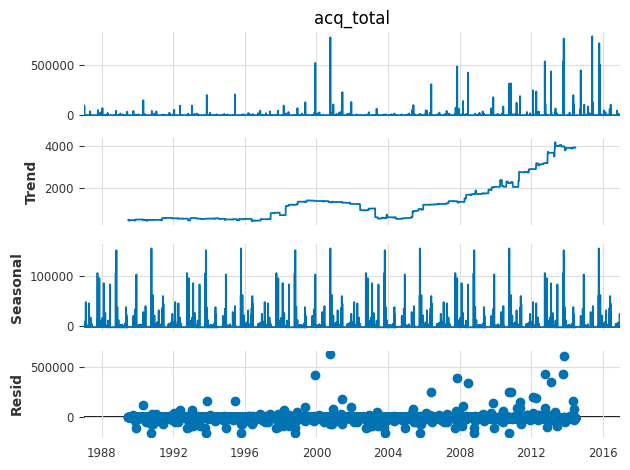

In [14]:
# Overall TS Decomposition
for days in [1, 7, 30, 365, (365 * 2), (365 * 3), (365 * 4), (365 * 5)]:  # Plotting against daily observations with daily, weekly, monthly, annual and bi-annual seasonality respectively.
    ts_data = final_dataset.set_index("acquisition_date").sort_index()["acq_total"]
    decomp = sm.tsa.seasonal_decompose(ts_data, period = days)
    decomp.plot();

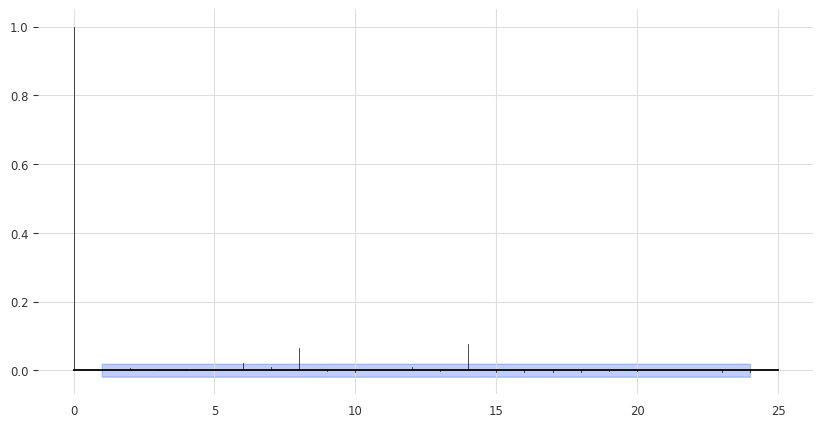

In [15]:
# Plot autocorrelation function
plot_acf(target_series)

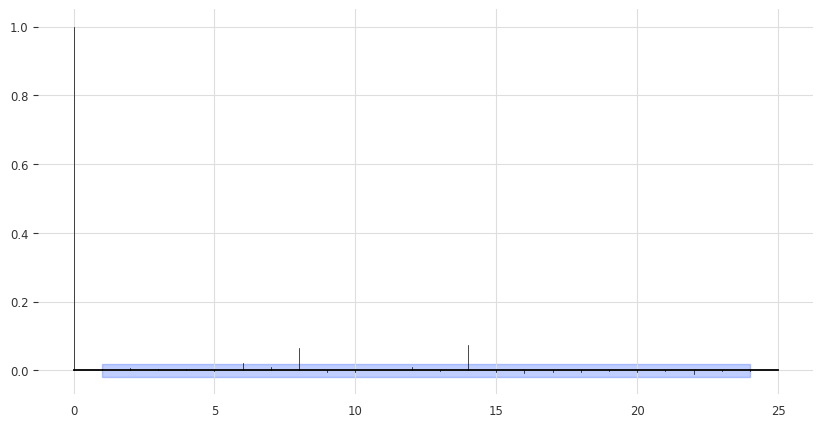

In [16]:
# Plot autocorrelation function
plot_pacf(target_series)

In [17]:
# Time Series Model Comparison Setup
lags = [-8, -14]

# Statistical and Machine Learning Models with gentle tuning
models = {
    # Baseline Statistical Models
    "Naive Forecast": NaiveDrift(),
    "7-day Moving Average": NaiveMovingAverage(7),  # Naive Weekly Moving Average
    "30-day Moving Average": NaiveMovingAverage(30),  # Naive Monthly Moving Average
    "1/2-Year Moving Average": NaiveMovingAverage((365//2)),  # Naive Half-Year Moving Average
    "1-Year Moving Average": NaiveMovingAverage(365),  # Naive Yearly Moving Average
    "3-Year Moving Average": NaiveMovingAverage(365 * 3),  # Naive 3-Year Moving Average
    "Exponential Smoothing": ExponentialSmoothing(seasonal_periods = (365 * 3), random_state = 10), # +1
    
    # Domain Specific Models - Intermittent Demand Forecasting
    "CROSTON Method": Croston(version = "optimized"),  # Modern Implementation of CROSTON
    "SBA": Croston(version = "sba"), # Syntetos-Boylan Approximation
    "TSB": Croston(version = "tsb", alpha_d = 0.1, alpha_p = 0.1), # Teunter-Syntetos-Babai

    # Multivariate ML models - Explainability metrics available
    "Decision Tree": RandomForest(lags = lags, output_chunk_length = 10, lags_past_covariates = [-8, -14],
                                  lags_future_covariates = [8, 14], random_state = 10, n_estimators = 1),  # +1
    "Random Forest (10)": RandomForest(lags = lags, output_chunk_length = 10, lags_past_covariates = [-8, -14],
                                  lags_future_covariates = [8, 14], random_state = 10, n_estimators = 10),  # +1
    "Random Forest (50)": RandomForest(lags = lags, output_chunk_length = 10, lags_past_covariates = [-8, -14],
                                  lags_future_covariates = [8, 14], random_state = 10, n_estimators = 50),  # +1 
    "Random Forest (100)": RandomForest(lags = lags, output_chunk_length = 10, lags_past_covariates = [-8, -14],
                                  lags_future_covariates = [8, 14], random_state = 10, n_estimators = 100),
    "Random Forest (200)": RandomForest(lags = lags, output_chunk_length = 10, lags_past_covariates = [-8, -14],
                                  lags_future_covariates = [8, 14], random_state = 10, n_estimators = 200),
    "LightGBM": LightGBMModel(lags = lags, output_chunk_length = 10, lags_past_covariates = [-8, -14],
                              lags_future_covariates = [8, 14], random_state = 10, n_estimators=350, learning_rate = 0.05, verbose = 0),
    "CatBoost": CatBoostModel(lags = lags, output_chunk_length = 10, lags_past_covariates = [-8, -14],
                              lags_future_covariates = [8, 14], random_state = 10, n_estimators=350, learning_rate = 0.05),  # +1
    
    # Ensemble method - Best of multiple ML approaches
    "Naive Ensemble (DT + RF(10))": NaiveEnsembleModel([
        RandomForest(lags = lags, output_chunk_length = 10, lags_past_covariates = [-8, -14],
                     lags_future_covariates = [8, 14], random_state = 10, n_estimators = 1),
        RandomForest(lags = lags, output_chunk_length = 10, lags_past_covariates = [-8, -14],
                     lags_future_covariates = [8, 14], random_state = 10, n_estimators = 10),
    ]),
    "Naive Ensemble (ES + DT)": NaiveEnsembleModel([
        ExponentialSmoothing(seasonal_periods = (365 * 3), random_state = 10),
        RandomForest(lags = lags, output_chunk_length = 10, lags_past_covariates = [-8, -14],
                     lags_future_covariates = [8, 14], random_state = 10, n_estimators = 1),
    ]),
    "Naive Ensemble (ES + RF(2))": NaiveEnsembleModel([
        ExponentialSmoothing(seasonal_periods = (365 * 3), random_state = 10),
        RandomForest(lags = lags, output_chunk_length = 10, lags_past_covariates = [-8, -14],
                     lags_future_covariates = [8, 14], random_state = 10, n_estimators = 2),
    ]),
    "Naive Ensemble (ES + RF(5))": NaiveEnsembleModel([
        ExponentialSmoothing(seasonal_periods = (365 * 3), random_state = 10),
        RandomForest(lags = lags, output_chunk_length = 10, lags_past_covariates = [-8, -14],
                     lags_future_covariates = [8, 14], random_state = 10, n_estimators = 5),
    ]),
    "Naive Ensemble (ES + RF(10))": NaiveEnsembleModel([
        ExponentialSmoothing(seasonal_periods = (365 * 3), random_state = 10),
        RandomForest(lags = lags, output_chunk_length = 10, lags_past_covariates = [-8, -14],
                     lags_future_covariates = [8, 14], random_state = 10, n_estimators = 10),
    ]),
    "Naive Ensemble (ES + RF(50))": NaiveEnsembleModel([
        ExponentialSmoothing(seasonal_periods = (365 * 3), random_state = 10),
        RandomForest(lags = lags, output_chunk_length = 10, lags_past_covariates = [-8, -14],
                     lags_future_covariates = [8, 14], random_state = 10, n_estimators = 50),
    ]),
    "Naive Ensemble (ES + RF(100))": NaiveEnsembleModel([
        ExponentialSmoothing(seasonal_periods = (365 * 3), random_state = 10),
        RandomForest(lags = lags, output_chunk_length = 10, lags_past_covariates = [-8, -14],
                     lags_future_covariates = [8, 14], random_state = 10, n_estimators = 100),
    ]),
    "Naive Ensemble (ES + RF(200))": NaiveEnsembleModel([
        ExponentialSmoothing(seasonal_periods = (365 * 3), random_state = 10),
        RandomForest(lags = lags, output_chunk_length = 10, lags_past_covariates = [-8, -14],
                     lags_future_covariates = [8, 14], random_state = 10, n_estimators = 200),
    ]),
    "Naive Ensemble (ES + CatBoost(300))": NaiveEnsembleModel([
        ExponentialSmoothing(seasonal_periods = (365 * 3), random_state = 10),
        CatBoostModel(lags = lags, output_chunk_length = 10, lags_past_covariates = [-8, -14],
                      lags_future_covariates = [8, 14], random_state = 10, n_estimators=300, learning_rate = 0.05),
    ])
}

Some `forecasting_models` in the ensemble do not support past covariates, the past covariates will be provided only to the models supporting them when calling fit()` or `predict()`. To hide these warnings, set `show_warnings=False`.
Some `forecasting_models` in the ensemble do not support future covariates, the future covariates will be provided only to the models supporting them when calling `fit()` or `predict()`. To hide these warnings, set `show_warnings=False`.
Some `forecasting_models` in the ensemble do not support past covariates, the past covariates will be provided only to the models supporting them when calling fit()` or `predict()`. To hide these warnings, set `show_warnings=False`.
Some `forecasting_models` in the ensemble do not support future covariates, the future covariates will be provided only to the models supporting them when calling `fit()` or `predict()`. To hide these warnings, set `show_warnings=False`.
Some `forecasting_models` in the ensemble do not support p

In [18]:
date_offset = clean_dataset["acquisition_date"].max() - pd.DateOffset(years = 10)

print(f"Training using data from before: {date_offset}")
print(f"and after: {clean_dataset['acquisition_date'].min()}")

Training using data from before: 2006-12-15 00:00:00
and after: 1986-12-18 00:00:00


Successfully stored model [Naive Forecast] and its results.


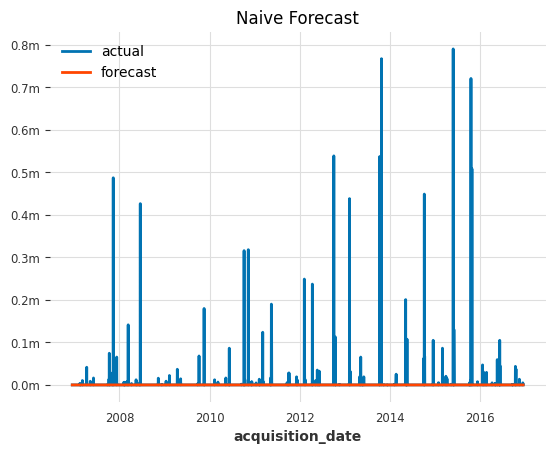

Successfully stored model [7-day Moving Average] and its results.


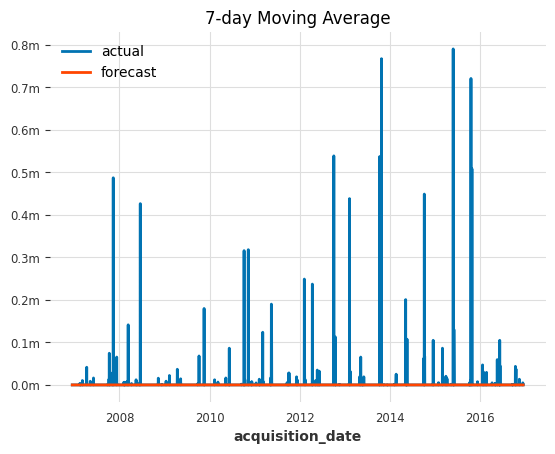

Successfully stored model [30-day Moving Average] and its results.


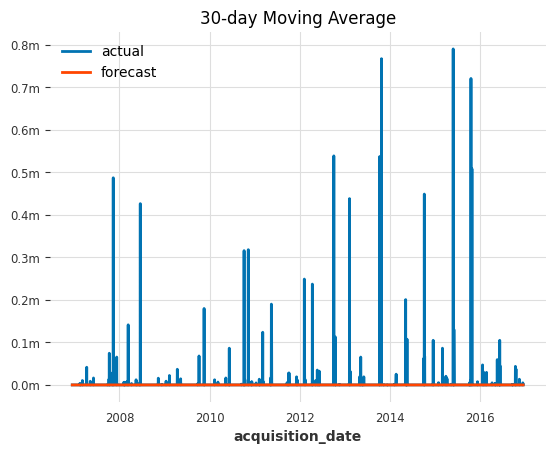

Successfully stored model [1/2-Year Moving Average] and its results.


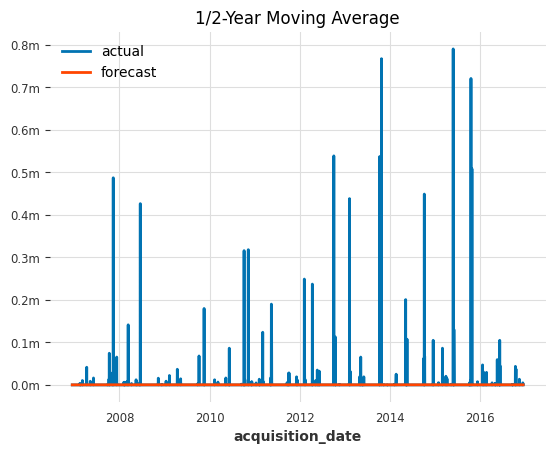

Successfully stored model [1-Year Moving Average] and its results.


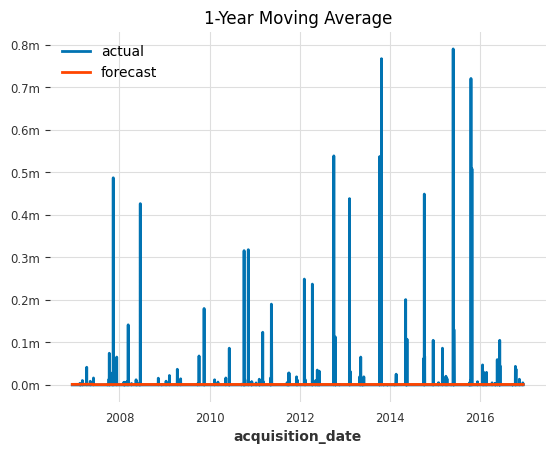

Successfully stored model [3-Year Moving Average] and its results.


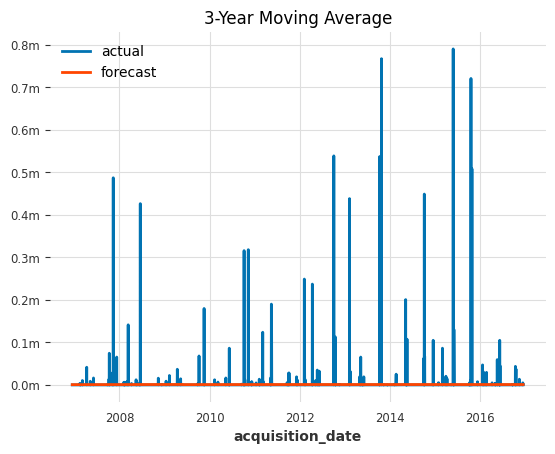

Successfully stored model [Exponential Smoothing] and its results.


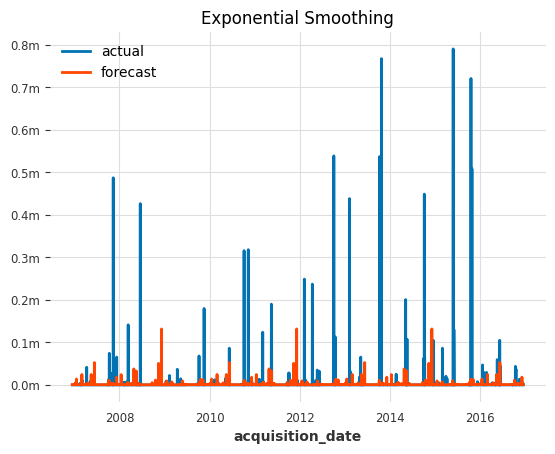

Successfully stored model [CROSTON Method] and its results.


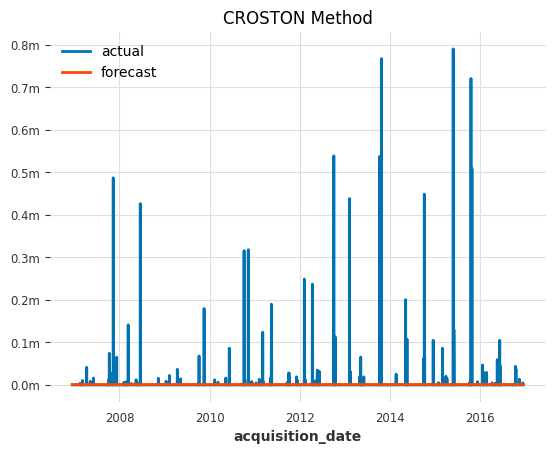

Successfully stored model [SBA] and its results.


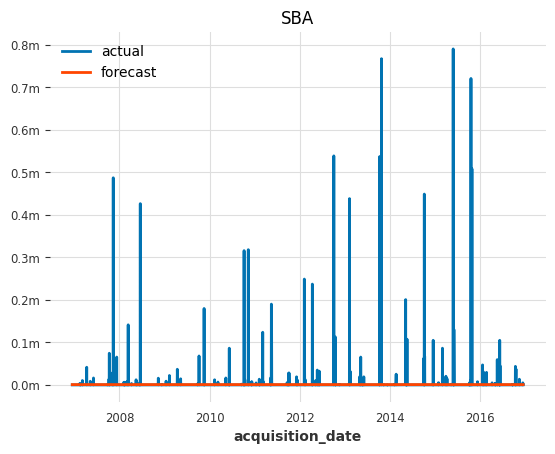

Successfully stored model [TSB] and its results.


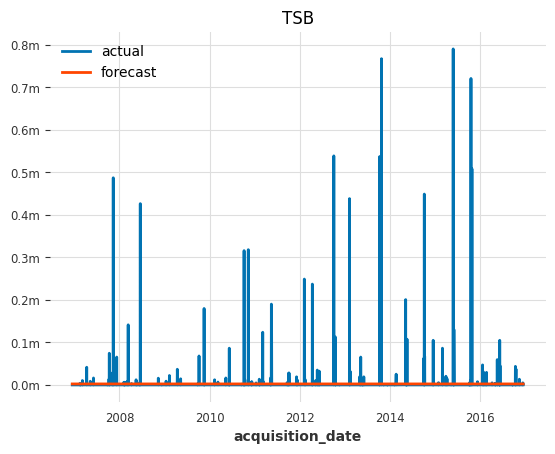

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Successfully stored model [Decision Tree] and its results.


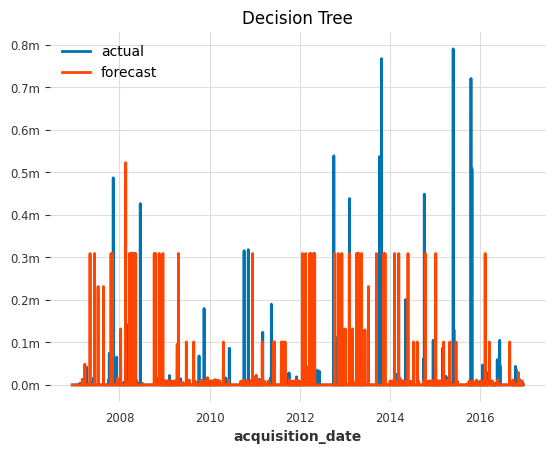

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Successfully stored model [Random Forest (10)] and its results.


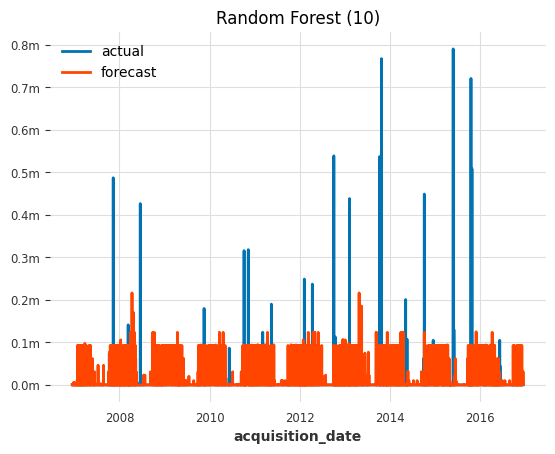

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Successfully stored model [Random Forest (50)] and its results.


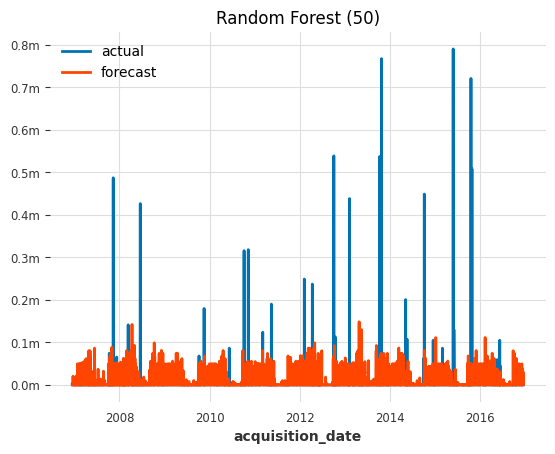

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Successfully stored model [Random Forest (100)] and its results.


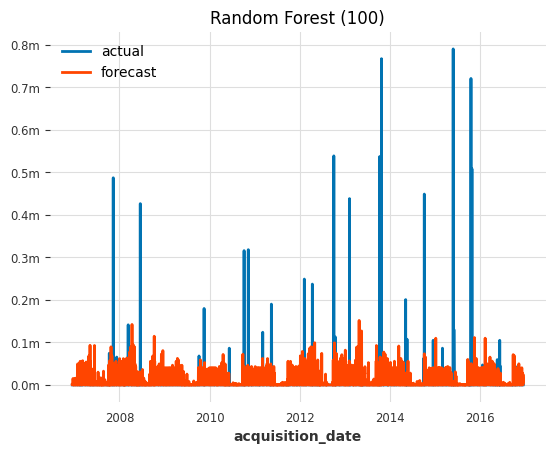

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Successfully stored model [Random Forest (200)] and its results.


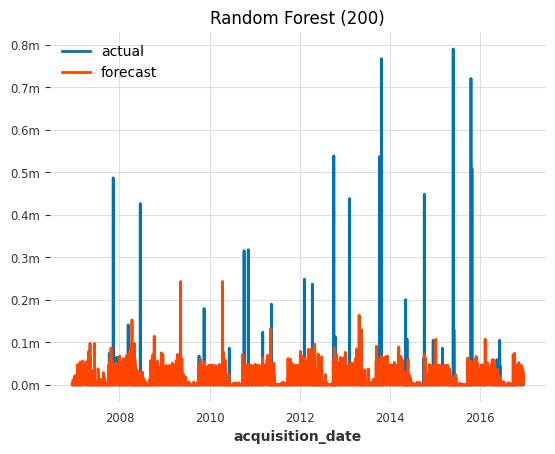

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Successfully stored model [LightGBM] and its results.


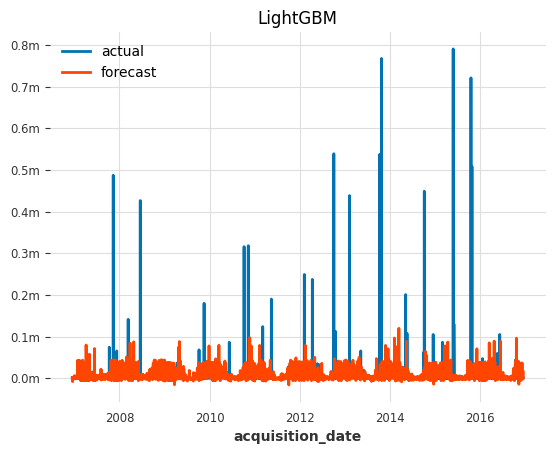

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Successfully stored model [CatBoost] and its results.


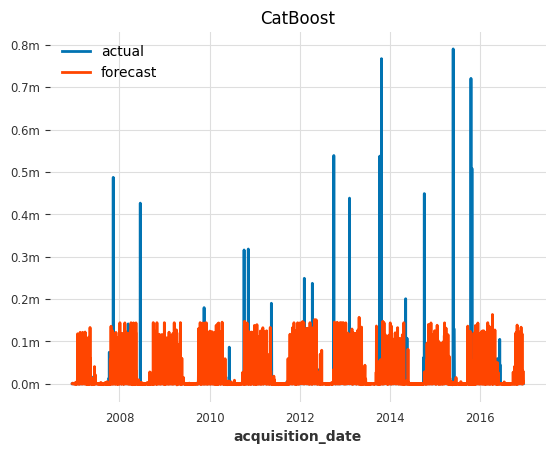

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Successfully stored model [Naive Ensemble (DT + RF(10))] and its results.


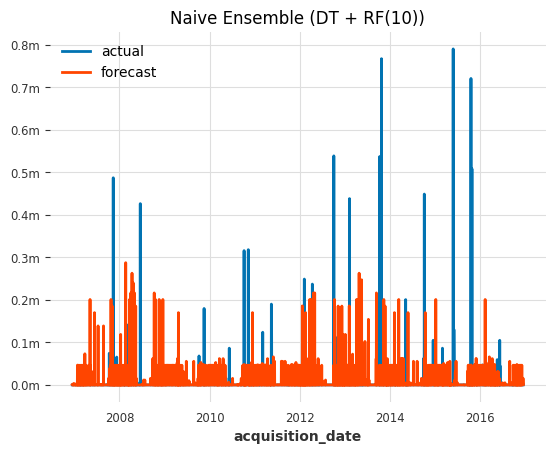

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Successfully stored model [Naive Ensemble (ES + DT)] and its results.


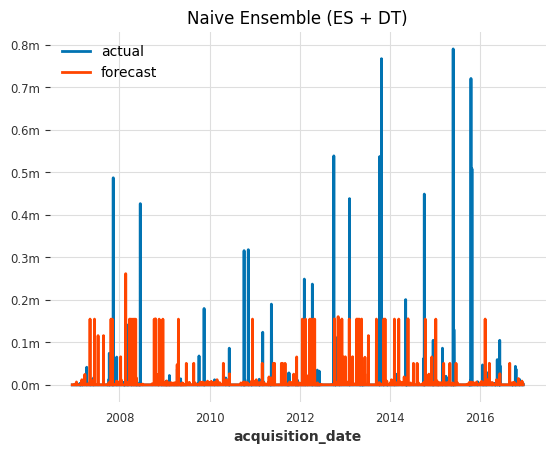

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Successfully stored model [Naive Ensemble (ES + RF(2))] and its results.


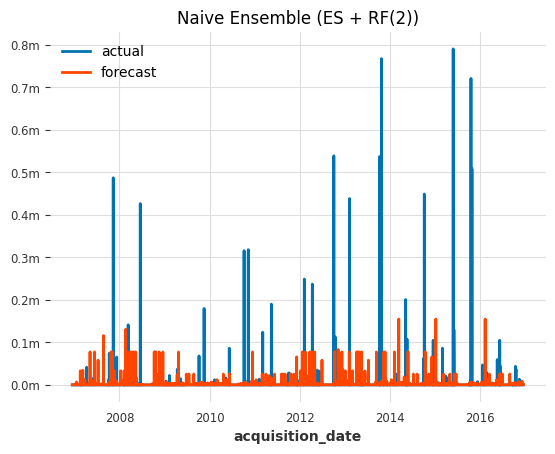

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Successfully stored model [Naive Ensemble (ES + RF(5))] and its results.


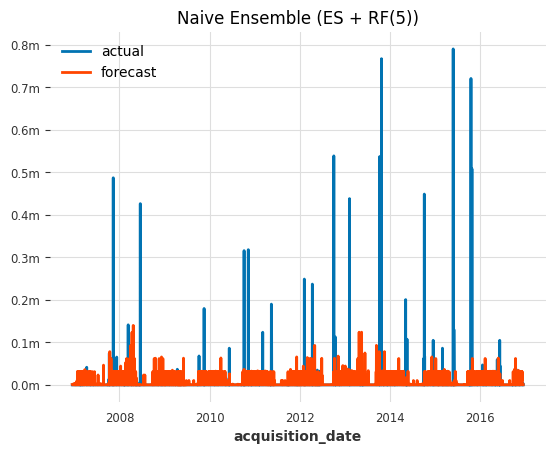

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Successfully stored model [Naive Ensemble (ES + RF(10))] and its results.


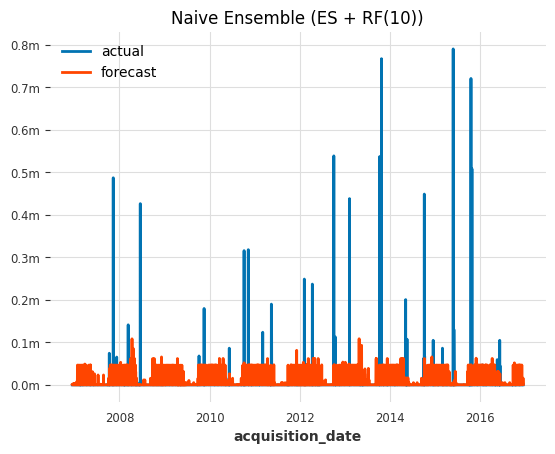

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Successfully stored model [Naive Ensemble (ES + RF(50))] and its results.


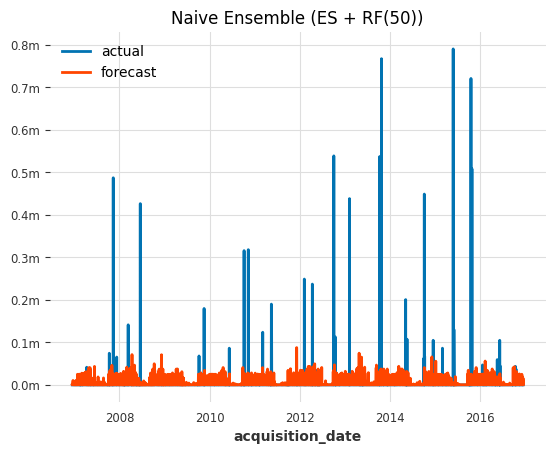

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Successfully stored model [Naive Ensemble (ES + RF(100))] and its results.


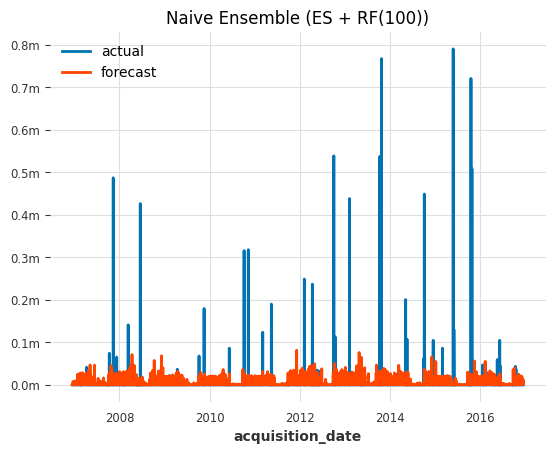

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Successfully stored model [Naive Ensemble (ES + RF(200))] and its results.


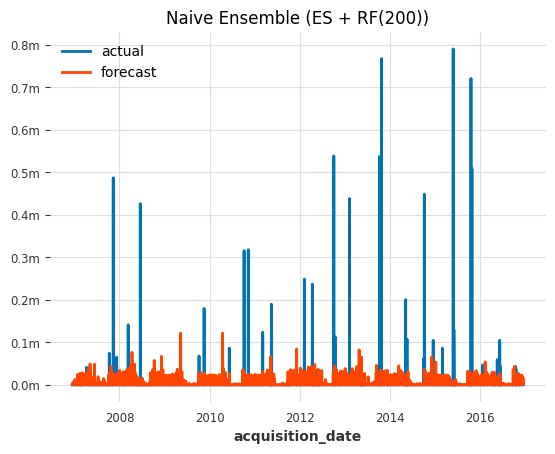

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Successfully stored model [Naive Ensemble (ES + CatBoost(300))] and its results.


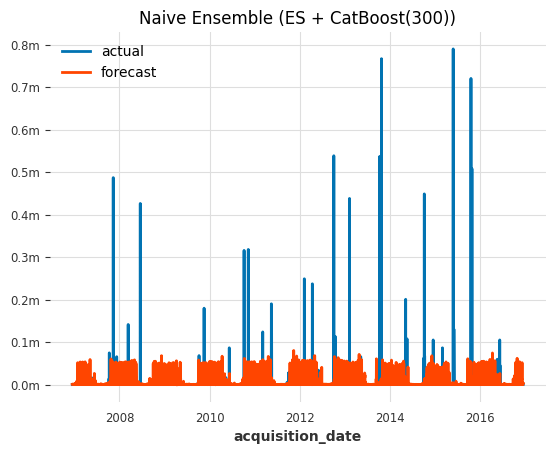

In [19]:
# Comparing Models for Selection
results = []
trained_models = defaultdict()
validation_data = ...
# How many periods to forecast out to
forecast_windows = [5, 10, 15, 20, 30, 50, 70, 100]
multivariate_models = ["Decision Tree", "Random Forest (10)", "Random Forest (50)", "Random Forest (100)", "Random Forest (200)", "CatBoost", "LightGBM", 
                       "Naive Ensemble (DT + RF(10))", "Naive Ensemble (ES + DT)",
                       "Naive Ensemble (ES + RF(2))", "Naive Ensemble (ES + RF(5))", "Naive Ensemble (ES + RF(10))", 
                       "Naive Ensemble (ES + RF(50))", "Naive Ensemble (ES + RF(100))", "Naive Ensemble (ES + RF(200))",
                       "Naive Ensemble (ES + CatBoost(300))"]

# Estimating forecasts using historical data
for model_name, model in models.items():
    # for window in forecast_windows:
    training_data, validation_data = target_series.split_before(date_offset)
    training_data = fill_missing_values(training_data, 0.0)
    validation_data = fill_missing_values(validation_data, 0.0)
    validation_length = len(validation_data)

    if model_name in multivariate_models:
        model.fit(training_data,
                  past_covariates = past_covariates,
                  future_covariates = future_covariates
                 )
    else:
        model.fit(training_data)

    if model_name in multivariate_models:
        predictions = model.predict(n = validation_length,
                                    past_covariates = past_covariates,
                                    future_covariates = future_covariates
                                   )
    else:
        predictions = model.predict(n = validation_length)


    # Metrics selected for model selection
    mae = metrics.mae(validation_data, predictions)
    rmse = np.sqrt(metrics.mse(validation_data, predictions))
    ope = metrics.ope(validation_data, predictions)
    
    # Calculate Coverage Probability (assuming a 95% prediction interval)
    pred_vals = predictions.values()
    validation_vals = validation_data.values()
    z_score = 1.96
    lower_bound = pred_vals - (z_score * np.std(pred_vals))
    upper_bound = pred_vals + (z_score * np.std(pred_vals))
    coverage_probability = np.mean((validation_vals >= lower_bound) & (validation_vals <= upper_bound))

    # Store all results
    model_results = defaultdict(int)
    model_results["Validation Data"] = validation_data
    model_results["Model Name"] = model_name
    model_results["MAE"] = mae
    model_results["OPE"] = ope / 100
    model_results["RMSE"] = rmse
    model_results["Coverage Probability"] = coverage_probability
    model_results["Predictions"] = predictions
    model_results["n-Predictions"] = len(predictions.values())
    
    # FIX: Residuals return a list of lists of a single float
    # model_results["Residuals"] = val_vals - pred_vals
    # model_results["Residuals"] = [v - p for (v, p) in zip(val_vals, pred_vals)]
    results.append(model_results)
    print(f"Successfully stored model [{model_name}] and its results.")
    
    validation_data.plot(label="actual")
    predictions.plot(label="forecast", color = "orangered")
    plt.title(model_name)
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000000:.1f}m'))
    plt.show()
    plt.close()

In [20]:
# Model performance visual comparisons
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(
    by = ["Coverage Probability", "RMSE", "MAE",],
    ascending = False
)

In [21]:
results_df["Rank"] = results_df.groupby("Model Name")["RMSE"].rank(ascending = True)
top_10 = results_df[(results_df["Rank"] <= 10) & (results_df["Coverage Probability"] > 0.3)]
top_10["Model Name"] = top_10["Model Name"].apply(lambda x: x.replace("Random Forest ", "RF").replace("Naive Ensemble ", ""))

In [22]:
results_df.to_csv("ML_Model_Results.csv")
top_10.to_csv("ML_Model_Results-Top10.csv")
pd.Series(validation_data).to_csv("ML_Model_Validation_Data.csv")

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

results_df = pd.read_csv("ML_Model_Results.csv", index_col = 0)
top_10 = pd.read_csv("ML_Model_Results-Top10.csv", index_col = 0)
validation_data = pd.read_csv("ML_Model_Validation_Data.csv", index_col = 0)

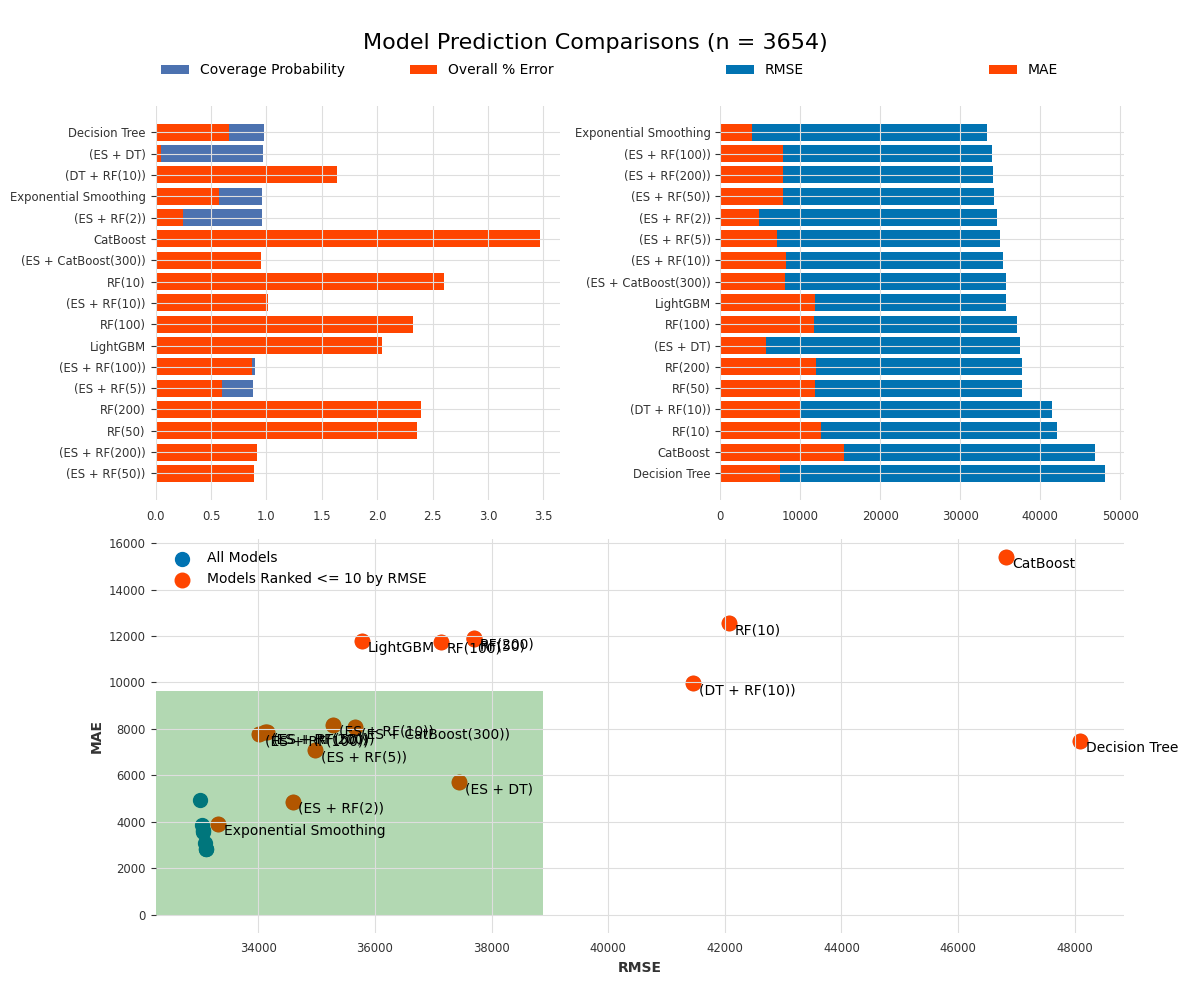

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

plt.suptitle(f"\nModel Prediction Comparisons (n = {top_10['n-Predictions'].values[0]})", fontsize = 16)
top_10 = top_10.sort_values(["Coverage Probability", "OPE"], ascending = [True, False])
axs[0, 0].barh(data = top_10, width = "Coverage Probability", y = "Model Name",
               color = sns.color_palette("deep")[0])
axs[0, 0].barh(data = top_10, width = "OPE", y = "Model Name",
               color="orangered")
axs[0, 0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc="upper left",
                 ncol=2, mode="expand", borderaxespad=0,
                 labels = ["Coverage Probability", "Overall % Error"])

top_10 = top_10.sort_values("RMSE", ascending = False)
axs[0, 1].barh(data = top_10, y = "Model Name", width = "RMSE")
axs[0, 1].barh(data = top_10, y = "Model Name", width = "MAE", color="orangered")
axs[0, 1].legend(bbox_to_anchor=(0., 1.02, 0.85, .102), loc="upper left",
           ncol=2, mode="expand", borderaxespad=0, labels = ["RMSE", "MAE"])

axs_bottom = fig.add_subplot(2, 1, 2)
axs_bottom.scatter(data = results_df, x = "RMSE", y = "MAE",
                   s = 100, norm = "log")
axs_bottom.scatter(data = top_10, x = "RMSE", y = "MAE",
                   s = 110, norm = "log", color = "orangered")
axs_bottom.legend(labels = ["All Models", "Models Ranked <= 10 by RMSE"])
axs_bottom.set_xlabel("RMSE")
axs_bottom.set_ylabel("MAE")
for index, row in top_10.iterrows():
    axs_bottom.text(row["RMSE"] + 100, row["MAE"], row["Model Name"], 
                    fontsize = 10, va="top", ha="left")

# "Goldilocks zone" for estimation
ax = plt.gca()
ax.axhspan(0, ax.get_ylim()[1] * 0.6,
           xmin = 0, xmax = 0.4,
           facecolor = "green", alpha = 0.3)
axs[1, 1].remove()
axs[1, 0].remove()

plt.tight_layout()
plt.show()
plt.close()

In [25]:
# Candidate Models for forecasting
candidates = ["Random Forest (200)", "Random Forest (50)"
              "Naive Ensemble (ES + RF(2))", "Naive Ensemble (ES + RF(10))", "Naive Ensemble (DT + RF(10))"]
candidate_results = results_df[results_df["Model Name"].isin(candidates)]
# candidate_validation_data = validation_data[validation_data["Model"].isin(candidates)]

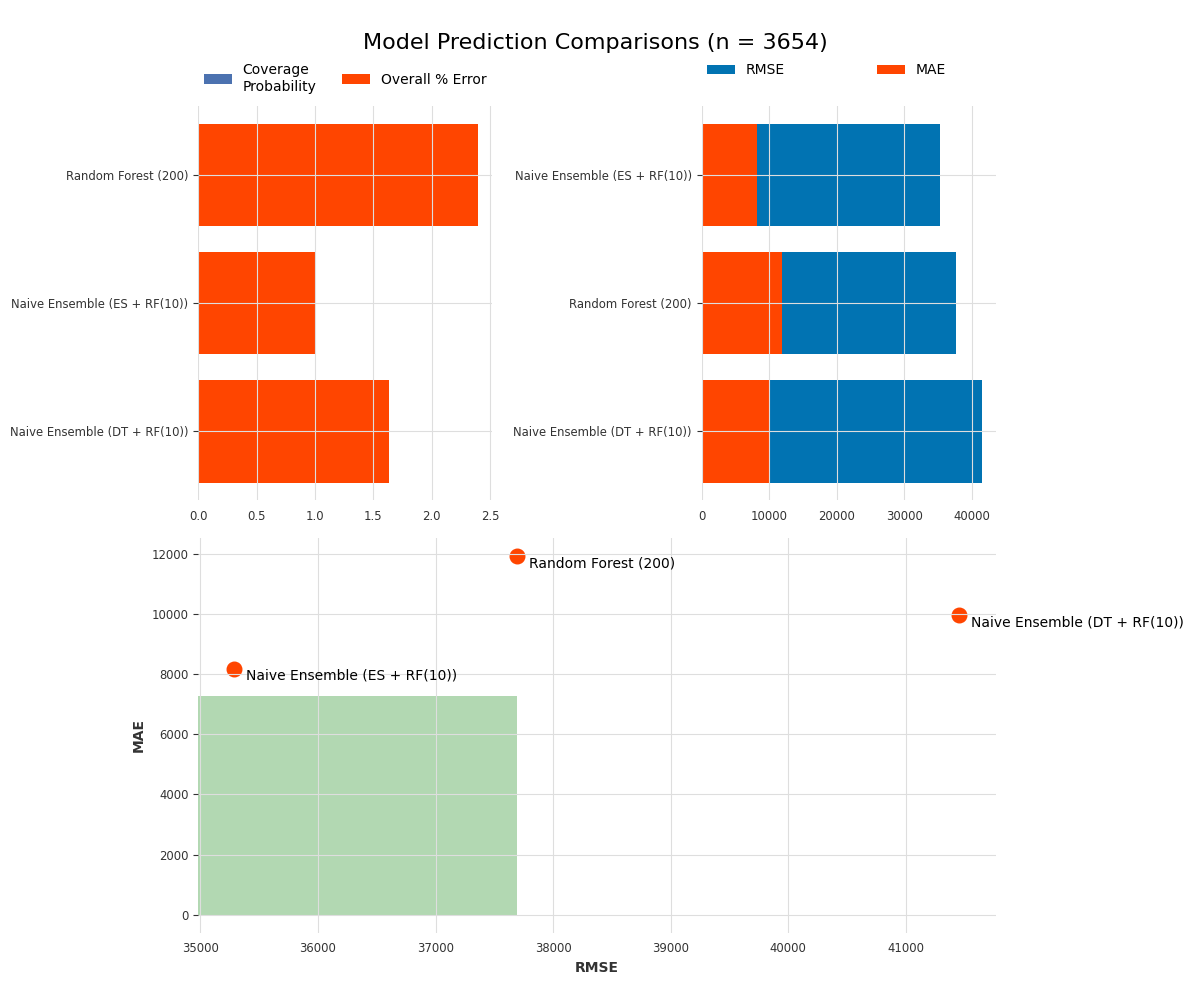

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

plt.suptitle(f"\nModel Prediction Comparisons (n = {candidate_results['n-Predictions'].values[0]})", fontsize = 16)
top_10 = top_10.sort_values(["Coverage Probability", "OPE"], ascending = [True, False])
axs[0, 0].barh(data = candidate_results, width = "Coverage Probability", y = "Model Name",
               color = sns.color_palette("deep")[0])
axs[0, 0].barh(data = candidate_results, width = "OPE", y = "Model Name",
               color="orangered")
axs[0, 0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc="upper left",
                 ncol=2, mode="expand", borderaxespad=0,
                 labels = ["Coverage\nProbability", "Overall % Error"])

candidate_results = candidate_results.sort_values("RMSE", ascending = False)
axs[0, 1].barh(data = candidate_results, y = "Model Name", width = "RMSE")
axs[0, 1].barh(data = candidate_results, y = "Model Name", width = "MAE", color="orangered")
axs[0, 1].legend(bbox_to_anchor=(0., 1.02, 0.85, .102), loc="upper left",
           ncol=2, mode="expand", borderaxespad=0, labels = ["RMSE", "MAE"])

axs_bottom = fig.add_subplot(2, 1, 2)
axs_bottom.scatter(data = candidate_results, x = "RMSE", y = "MAE",
                   s = 110, norm = "log", color = "orangered")
axs_bottom.set_xlabel("RMSE")
axs_bottom.set_ylabel("MAE")
for index, row in candidate_results.iterrows():
    axs_bottom.text(row["RMSE"] + 100, row["MAE"], row["Model Name"], 
                    fontsize = 10, va="top", ha="left")

# "Goldilocks zone" for estimation
ax = plt.gca()
ax.axhspan(0, ax.get_ylim()[1] * 0.6, 
           xmin = 0, xmax = 0.4, 
           facecolor = "green", alpha = 0.3)

axs[1, 1].remove()
axs[1, 0].remove()

plt.tight_layout()
plt.show()
plt.close()

In [27]:
# extracting model estimates
model_num = 20
predictions = results[model_num]["Predictions"].pd_dataframe()
validation = results[model_num]["Validation Data"].pd_dataframe()

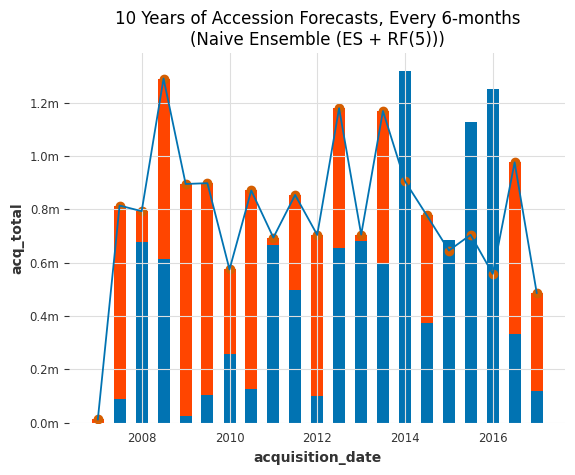

In [28]:
# Forecasts for 10 years, 6 months at a time
data_6m = predictions.resample("6M").sum()
val_6m = validation.resample("6M").sum()

data_6m["Month"] = data_6m.index.month_name()
data_6m["Quarter"] = data_6m.index.quarter
data_6m["Year"] = data_6m.index.year

sns.lineplot(data_6m.acq_total)
plt.bar(data_6m.index, data_6m.acq_total.values, width = 100, color = "orangered")
plt.bar(val_6m.index, val_6m.acq_total.values, width = 100)
plt.scatter(data_6m.index, data_6m.acq_total.values, color = sns.color_palette()[3])
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000000:.1f}m'))

plt.title(f"10 Years of Accession Forecasts, Every 6-months\n({results[model_num]["Model Name"]})");

In [29]:
(data_6m
 .reset_index()
 # .drop("index", axis = 1)
)

component,acquisition_date,acq_total,Month,Quarter,Year
0,2006-12-31,"12,478.76",December,4,2006
1,2007-06-30,"814,742.08",June,2,2007
2,2007-12-31,"793,609.73",December,4,2007
3,2008-06-30,"1,291,304.75",June,2,2008
4,2008-12-31,"895,730.48",December,4,2008
5,2009-06-30,"898,654.59",June,2,2009
6,2009-12-31,"575,069.65",December,4,2009
7,2010-06-30,"871,314.65",June,2,2010
8,2010-12-31,"694,474.17",December,4,2010
9,2011-06-30,"854,627.37",June,2,2011


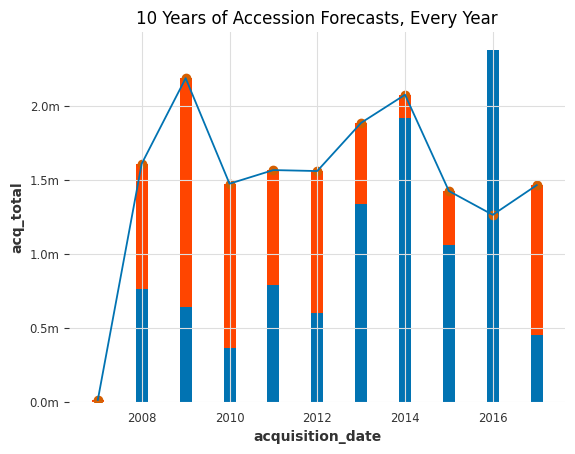

In [30]:
# 1 year
data_Y = predictions.resample("Y").sum()
val_Y = validation.resample("Y").sum()

data_Y["Month"] = data_Y.index.month_name()
data_Y["Quarter"] = data_Y.index.quarter
data_Y["Year"] = data_Y.index.year

sns.lineplot(data_Y.acq_total)
plt.bar(data_Y.index, data_Y.acq_total.values, width = 100, color = "orangered")
plt.bar(val_Y.index, val_Y.acq_total.values, width = 100)
plt.scatter(data_Y.index, data_Y.acq_total.values, color = sns.color_palette()[3])
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000000:.1f}m'))
plt.title("10 Years of Accession Forecasts, Every Year");

In [31]:
(data_Y
 .reset_index()
 # .drop("index", axis = 1)
)

component,acquisition_date,acq_total,Month,Quarter,Year
0,2006-12-31,"12,478.76",December,4,2006
1,2007-12-31,"1,608,351.81",December,4,2007
2,2008-12-31,"2,187,035.23",December,4,2008
3,2009-12-31,"1,473,724.24",December,4,2009
4,2010-12-31,"1,565,788.82",December,4,2010
5,2011-12-31,"1,559,238.53",December,4,2011
6,2012-12-31,"1,885,584.12",December,4,2012
7,2013-12-31,"2,075,045.86",December,4,2013
8,2014-12-31,"1,424,189.01",December,4,2014
9,2015-12-31,"1,263,257.64",December,4,2015


In [32]:
# Another potential opportunity
# ref: https://stats.stackexchange.com/a/8782

# Alternative model, create a model of sales per period using pandas and numpy to preserve as much data as possible.
# Convert intake to intake-per-period: 
# intake-per-period = observed intake / (n-periods w/o intake)

Potential Future Features:
- [ ] Hierarchical Modeling (e.g. by Department, by Credit, etc.)
- [ ] Popular ML models (ARIMA, RandomForest, MCMC, etc.)
- [ ] With Multi-variate Models, we can have SHAP feature importance explanation.
- [ ] Calculating Backlog durations.

# We're about the process!
If streamlining means less people work, we want less of it. Data belong to the social.